# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

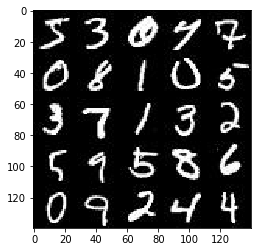

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

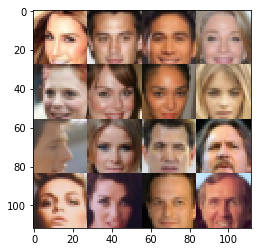

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0


C:\Users\alceu\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, 
                                shape=(None, image_width, image_height, image_channels), 
                                name='input_real')
    z_input = tf.placeholder(tf.float32, 
                             shape=(None, z_dim), 
                             name='noise_input')
    learn_rate = tf.placeholder(tf.float32, shape=(), name='learn_rate')

    return input_real, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Input images are either 28x28x3 or 28x28x1.
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st Convolutional layer.
        conv1 = tf.layers.conv2d(images, 32, 5, 2, padding='same')
        conv1 = tf.maximum(alpha*conv1, conv1) # conv1.shape = (16, 16, 32)
        
        # 2nd Convolutional layer.
        conv2 = tf.layers.conv2d(conv1, 64, 5, 2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2) # conv1.shape = (8, 8, 64)
        
        # 3rd Convolutional layer.
        conv3 = tf.layers.conv2d(conv2, 128, 5, 2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3) # conv1.shape = (4, 4, 128)
        
        # Output layer.
        conv3 = tf.reshape(conv3, (-1, 4*4*128)) # Flatten.
        logits = tf.layers.dense(conv3, 1, activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :re
    turn: The tensor output of the generator
    """
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, units=7*7*512)
        x = tf.reshape(x, [-1, 7, 7, 512])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x) # x.shape = (7, 7, 512)
        
        # 1st Convolution.
        conv1 = tf.layers.conv2d_transpose(x, filters=256, kernel_size=5, 
                                           strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1) # conv1.shape = (14, 14, 256)
        
        # Convolution to output.
        logits = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 
                                            strides=2, padding='same')
        # logits.shape = (28, 28, out_channel_dim)
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    
    _, d_logits_real = discriminator(input_real, reuse=False)
    d_labels_real = tf.ones_like(d_logits_real) * (1.0 - smooth)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=d_labels_real))
    _, d_logits_fake = discriminator(input_fake, reuse=True)
    d_labels_fake = tf.zeros_like(d_logits_fake)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=d_labels_fake))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.split('/')[0] == 'generator']
    d_vars = [v for v in t_vars if v.name.split('/')[0] == 'discriminator']

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_counter = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):                
                
                # Sample random noise for the generator.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # Print generator output.
                batch_counter += 1
                if (batch_counter % 100) == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)
                    
                # Print losses.
                if (batch_counter % 10) == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch Count {}...".format(batch_counter),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch Count 10... Discriminator Loss: 0.5437... Generator Loss: 2.2808
Epoch 1/2... Batch Count 20... Discriminator Loss: 0.5306... Generator Loss: 2.8746
Epoch 1/2... Batch Count 30... Discriminator Loss: 0.8508... Generator Loss: 1.8003
Epoch 1/2... Batch Count 40... Discriminator Loss: 1.3249... Generator Loss: 0.8137
Epoch 1/2... Batch Count 50... Discriminator Loss: 0.6907... Generator Loss: 1.9652
Epoch 1/2... Batch Count 60... Discriminator Loss: 1.5403... Generator Loss: 0.4708
Epoch 1/2... Batch Count 70... Discriminator Loss: 1.9970... Generator Loss: 0.2979
Epoch 1/2... Batch Count 80... Discriminator Loss: 0.7258... Generator Loss: 1.7839
Epoch 1/2... Batch Count 90... Discriminator Loss: 0.6815... Generator Loss: 2.6725


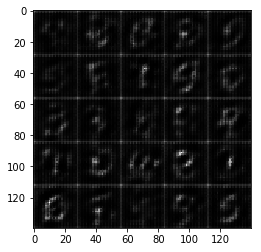

Epoch 1/2... Batch Count 100... Discriminator Loss: 0.4896... Generator Loss: 2.4665
Epoch 1/2... Batch Count 110... Discriminator Loss: 0.4435... Generator Loss: 2.5199
Epoch 1/2... Batch Count 120... Discriminator Loss: 1.5755... Generator Loss: 6.5327
Epoch 1/2... Batch Count 130... Discriminator Loss: 0.5154... Generator Loss: 2.5895
Epoch 1/2... Batch Count 140... Discriminator Loss: 0.3868... Generator Loss: 4.2236
Epoch 1/2... Batch Count 150... Discriminator Loss: 0.4051... Generator Loss: 3.0591
Epoch 1/2... Batch Count 160... Discriminator Loss: 0.3421... Generator Loss: 6.5012
Epoch 1/2... Batch Count 170... Discriminator Loss: 0.3411... Generator Loss: 6.1115
Epoch 1/2... Batch Count 180... Discriminator Loss: 0.3646... Generator Loss: 3.9647
Epoch 1/2... Batch Count 190... Discriminator Loss: 0.3589... Generator Loss: 3.8363


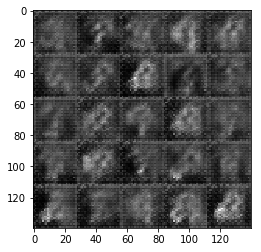

Epoch 1/2... Batch Count 200... Discriminator Loss: 0.5819... Generator Loss: 2.8619
Epoch 1/2... Batch Count 210... Discriminator Loss: 0.9862... Generator Loss: 4.3972
Epoch 1/2... Batch Count 220... Discriminator Loss: 2.7272... Generator Loss: 0.1607
Epoch 1/2... Batch Count 230... Discriminator Loss: 0.4842... Generator Loss: 6.7461
Epoch 1/2... Batch Count 240... Discriminator Loss: 0.3630... Generator Loss: 5.0809
Epoch 1/2... Batch Count 250... Discriminator Loss: 1.5091... Generator Loss: 7.8417
Epoch 1/2... Batch Count 260... Discriminator Loss: 0.3963... Generator Loss: 3.7496
Epoch 1/2... Batch Count 270... Discriminator Loss: 1.0361... Generator Loss: 0.8477
Epoch 1/2... Batch Count 280... Discriminator Loss: 0.4088... Generator Loss: 5.0489
Epoch 1/2... Batch Count 290... Discriminator Loss: 1.0430... Generator Loss: 2.0976


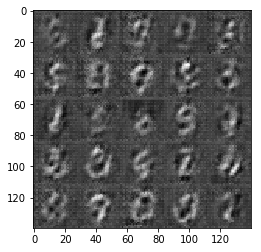

Epoch 1/2... Batch Count 300... Discriminator Loss: 1.3444... Generator Loss: 0.6798
Epoch 1/2... Batch Count 310... Discriminator Loss: 1.0684... Generator Loss: 4.3355
Epoch 1/2... Batch Count 320... Discriminator Loss: 1.6973... Generator Loss: 0.3419
Epoch 1/2... Batch Count 330... Discriminator Loss: 1.3558... Generator Loss: 0.7210
Epoch 1/2... Batch Count 340... Discriminator Loss: 1.0536... Generator Loss: 0.8197
Epoch 1/2... Batch Count 350... Discriminator Loss: 0.4009... Generator Loss: 6.6757
Epoch 1/2... Batch Count 360... Discriminator Loss: 0.6626... Generator Loss: 1.4418
Epoch 1/2... Batch Count 370... Discriminator Loss: 1.6558... Generator Loss: 0.3613
Epoch 1/2... Batch Count 380... Discriminator Loss: 1.0996... Generator Loss: 1.0514
Epoch 1/2... Batch Count 390... Discriminator Loss: 0.7664... Generator Loss: 1.2948


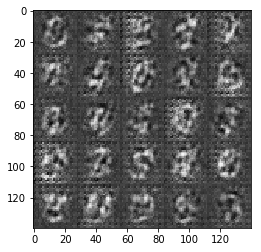

Epoch 1/2... Batch Count 400... Discriminator Loss: 0.4861... Generator Loss: 2.1819


KeyboardInterrupt: 

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Batch Count 10... Discriminator Loss: 0.6131... Generator Loss: 2.1067
Epoch 1/2... Batch Count 20... Discriminator Loss: 0.4042... Generator Loss: 3.6879
Epoch 1/2... Batch Count 30... Discriminator Loss: 0.4075... Generator Loss: 3.8462
Epoch 1/2... Batch Count 40... Discriminator Loss: 0.5081... Generator Loss: 2.3485
Epoch 1/2... Batch Count 50... Discriminator Loss: 0.3576... Generator Loss: 6.7306
Epoch 1/2... Batch Count 60... Discriminator Loss: 0.3604... Generator Loss: 5.4738
Epoch 1/2... Batch Count 70... Discriminator Loss: 0.3353... Generator Loss: 5.7974
Epoch 1/2... Batch Count 80... Discriminator Loss: 0.4281... Generator Loss: 3.0280
Epoch 1/2... Batch Count 90... Discriminator Loss: 0.3734... Generator Loss: 5.0627


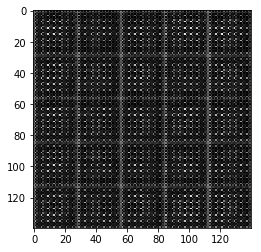

Epoch 1/2... Batch Count 100... Discriminator Loss: 0.3446... Generator Loss: 6.3200
Epoch 1/2... Batch Count 110... Discriminator Loss: 0.4305... Generator Loss: 3.2688
Epoch 1/2... Batch Count 120... Discriminator Loss: 0.4283... Generator Loss: 3.4505
Epoch 1/2... Batch Count 130... Discriminator Loss: 0.4140... Generator Loss: 4.0049
Epoch 1/2... Batch Count 140... Discriminator Loss: 0.4482... Generator Loss: 3.1717
Epoch 1/2... Batch Count 150... Discriminator Loss: 0.3529... Generator Loss: 6.0263
Epoch 1/2... Batch Count 160... Discriminator Loss: 0.3628... Generator Loss: 5.5108
Epoch 1/2... Batch Count 170... Discriminator Loss: 0.3550... Generator Loss: 4.8553
Epoch 1/2... Batch Count 180... Discriminator Loss: 0.4440... Generator Loss: 3.3163
Epoch 1/2... Batch Count 190... Discriminator Loss: 0.3731... Generator Loss: 11.5190


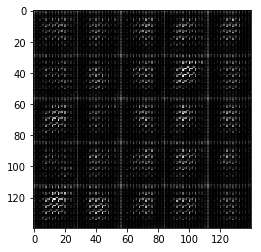

Epoch 1/2... Batch Count 200... Discriminator Loss: 0.4257... Generator Loss: 3.0064
Epoch 1/2... Batch Count 210... Discriminator Loss: 0.3476... Generator Loss: 7.6597
Epoch 1/2... Batch Count 220... Discriminator Loss: 0.3442... Generator Loss: 5.9156
Epoch 1/2... Batch Count 230... Discriminator Loss: 0.3505... Generator Loss: 4.7887
Epoch 1/2... Batch Count 240... Discriminator Loss: 0.3597... Generator Loss: 6.2969
Epoch 1/2... Batch Count 250... Discriminator Loss: 0.3592... Generator Loss: 4.0574
Epoch 1/2... Batch Count 260... Discriminator Loss: 0.3561... Generator Loss: 4.9789
Epoch 1/2... Batch Count 270... Discriminator Loss: 0.3428... Generator Loss: 5.5262
Epoch 1/2... Batch Count 280... Discriminator Loss: 0.3413... Generator Loss: 5.2308
Epoch 1/2... Batch Count 290... Discriminator Loss: 0.3670... Generator Loss: 3.7840


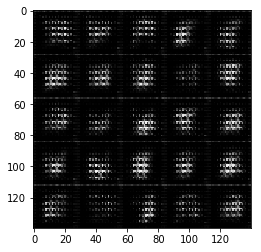

Epoch 1/2... Batch Count 300... Discriminator Loss: 0.4086... Generator Loss: 2.9901
Epoch 1/2... Batch Count 310... Discriminator Loss: 0.3683... Generator Loss: 3.9738
Epoch 1/2... Batch Count 320... Discriminator Loss: 0.3858... Generator Loss: 3.4215
Epoch 1/2... Batch Count 330... Discriminator Loss: 0.4469... Generator Loss: 3.2917
Epoch 1/2... Batch Count 340... Discriminator Loss: 0.4141... Generator Loss: 3.1843
Epoch 1/2... Batch Count 350... Discriminator Loss: 0.3838... Generator Loss: 5.5424
Epoch 1/2... Batch Count 360... Discriminator Loss: 0.4023... Generator Loss: 5.3898
Epoch 1/2... Batch Count 370... Discriminator Loss: 0.4255... Generator Loss: 3.4117
Epoch 1/2... Batch Count 380... Discriminator Loss: 0.4080... Generator Loss: 3.7947
Epoch 1/2... Batch Count 390... Discriminator Loss: 0.4075... Generator Loss: 3.6066


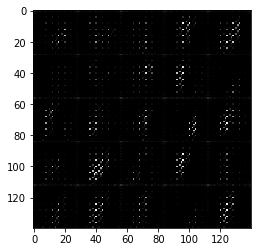

Epoch 1/2... Batch Count 400... Discriminator Loss: 0.3611... Generator Loss: 5.8184
Epoch 1/2... Batch Count 410... Discriminator Loss: 0.3722... Generator Loss: 4.7664
Epoch 1/2... Batch Count 420... Discriminator Loss: 0.3594... Generator Loss: 5.6045
Epoch 1/2... Batch Count 430... Discriminator Loss: 0.3746... Generator Loss: 8.0068
Epoch 1/2... Batch Count 440... Discriminator Loss: 0.3431... Generator Loss: 7.4118
Epoch 1/2... Batch Count 450... Discriminator Loss: 0.3448... Generator Loss: 6.6671
Epoch 1/2... Batch Count 460... Discriminator Loss: 0.3388... Generator Loss: 6.7960
Epoch 1/2... Batch Count 470... Discriminator Loss: 0.3369... Generator Loss: 7.1967
Epoch 1/2... Batch Count 480... Discriminator Loss: 0.3372... Generator Loss: 6.8136
Epoch 1/2... Batch Count 490... Discriminator Loss: 0.3327... Generator Loss: 6.9978


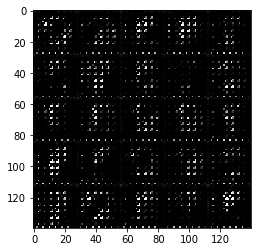

Epoch 1/2... Batch Count 500... Discriminator Loss: 0.3469... Generator Loss: 6.2912
Epoch 1/2... Batch Count 510... Discriminator Loss: 0.3433... Generator Loss: 6.5082
Epoch 1/2... Batch Count 520... Discriminator Loss: 0.3345... Generator Loss: 6.0252
Epoch 1/2... Batch Count 530... Discriminator Loss: 0.3321... Generator Loss: 7.1486
Epoch 1/2... Batch Count 540... Discriminator Loss: 0.3324... Generator Loss: 6.9196
Epoch 1/2... Batch Count 550... Discriminator Loss: 0.3365... Generator Loss: 6.6629
Epoch 1/2... Batch Count 560... Discriminator Loss: 0.3371... Generator Loss: 7.0785
Epoch 1/2... Batch Count 570... Discriminator Loss: 0.3304... Generator Loss: 6.8956
Epoch 1/2... Batch Count 580... Discriminator Loss: 0.3350... Generator Loss: 6.9264
Epoch 1/2... Batch Count 590... Discriminator Loss: 0.3300... Generator Loss: 7.0930


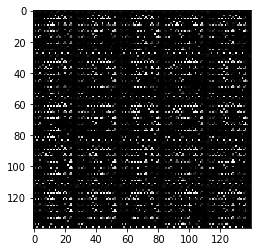

Epoch 1/2... Batch Count 600... Discriminator Loss: 0.3378... Generator Loss: 7.4556
Epoch 1/2... Batch Count 610... Discriminator Loss: 0.3343... Generator Loss: 6.7383
Epoch 1/2... Batch Count 620... Discriminator Loss: 0.3561... Generator Loss: 6.3338
Epoch 1/2... Batch Count 630... Discriminator Loss: 0.3377... Generator Loss: 7.6541
Epoch 1/2... Batch Count 640... Discriminator Loss: 0.3333... Generator Loss: 7.3069
Epoch 1/2... Batch Count 650... Discriminator Loss: 0.3323... Generator Loss: 6.9116
Epoch 1/2... Batch Count 660... Discriminator Loss: 0.3316... Generator Loss: 6.9852
Epoch 1/2... Batch Count 670... Discriminator Loss: 0.3362... Generator Loss: 6.8693
Epoch 1/2... Batch Count 680... Discriminator Loss: 0.3295... Generator Loss: 7.0899
Epoch 1/2... Batch Count 690... Discriminator Loss: 0.3314... Generator Loss: 6.0606


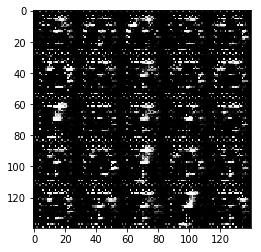

Epoch 1/2... Batch Count 700... Discriminator Loss: 0.3449... Generator Loss: 4.5177
Epoch 1/2... Batch Count 710... Discriminator Loss: 0.3503... Generator Loss: 4.1912
Epoch 1/2... Batch Count 720... Discriminator Loss: 0.3789... Generator Loss: 3.4878
Epoch 1/2... Batch Count 730... Discriminator Loss: 0.4138... Generator Loss: 3.1441
Epoch 1/2... Batch Count 740... Discriminator Loss: 0.3703... Generator Loss: 4.3764
Epoch 1/2... Batch Count 750... Discriminator Loss: 0.4341... Generator Loss: 3.4424
Epoch 1/2... Batch Count 760... Discriminator Loss: 0.3675... Generator Loss: 4.8717
Epoch 1/2... Batch Count 770... Discriminator Loss: 0.3892... Generator Loss: 4.3591
Epoch 1/2... Batch Count 780... Discriminator Loss: 0.4088... Generator Loss: 3.7565
Epoch 1/2... Batch Count 790... Discriminator Loss: 0.3825... Generator Loss: 4.2614


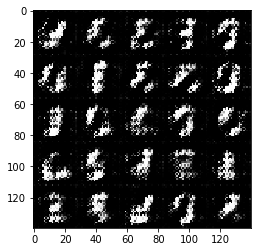

Epoch 1/2... Batch Count 800... Discriminator Loss: 0.3693... Generator Loss: 4.0310
Epoch 1/2... Batch Count 810... Discriminator Loss: 0.3822... Generator Loss: 5.5648
Epoch 1/2... Batch Count 820... Discriminator Loss: 0.3754... Generator Loss: 4.4796
Epoch 1/2... Batch Count 830... Discriminator Loss: 0.3641... Generator Loss: 5.5266
Epoch 1/2... Batch Count 840... Discriminator Loss: 0.3728... Generator Loss: 4.6468
Epoch 1/2... Batch Count 850... Discriminator Loss: 0.3532... Generator Loss: 5.2412
Epoch 1/2... Batch Count 860... Discriminator Loss: 0.3498... Generator Loss: 4.9792
Epoch 1/2... Batch Count 870... Discriminator Loss: 0.3675... Generator Loss: 4.0849
Epoch 1/2... Batch Count 880... Discriminator Loss: 0.3473... Generator Loss: 5.1116
Epoch 1/2... Batch Count 890... Discriminator Loss: 0.3445... Generator Loss: 5.5375


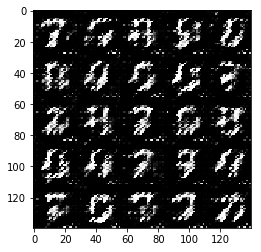

Epoch 1/2... Batch Count 900... Discriminator Loss: 0.3677... Generator Loss: 4.5663
Epoch 1/2... Batch Count 910... Discriminator Loss: 0.3491... Generator Loss: 4.7841
Epoch 1/2... Batch Count 920... Discriminator Loss: 0.3422... Generator Loss: 6.1979
Epoch 1/2... Batch Count 930... Discriminator Loss: 0.3414... Generator Loss: 5.3602
Epoch 1/2... Batch Count 940... Discriminator Loss: 0.3370... Generator Loss: 5.6489
Epoch 1/2... Batch Count 950... Discriminator Loss: 0.3446... Generator Loss: 5.0050
Epoch 1/2... Batch Count 960... Discriminator Loss: 0.3411... Generator Loss: 5.0035
Epoch 1/2... Batch Count 970... Discriminator Loss: 0.3416... Generator Loss: 5.7823
Epoch 1/2... Batch Count 980... Discriminator Loss: 0.3677... Generator Loss: 4.4196
Epoch 1/2... Batch Count 990... Discriminator Loss: 0.3541... Generator Loss: 6.3217


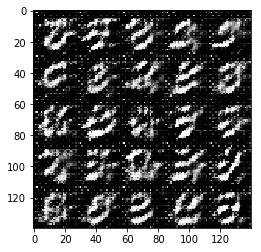

Epoch 1/2... Batch Count 1000... Discriminator Loss: 0.3442... Generator Loss: 5.7409
Epoch 1/2... Batch Count 1010... Discriminator Loss: 0.3492... Generator Loss: 5.0806
Epoch 1/2... Batch Count 1020... Discriminator Loss: 0.3539... Generator Loss: 5.3682
Epoch 1/2... Batch Count 1030... Discriminator Loss: 0.3355... Generator Loss: 5.5168
Epoch 1/2... Batch Count 1040... Discriminator Loss: 0.3425... Generator Loss: 5.0983
Epoch 1/2... Batch Count 1050... Discriminator Loss: 0.3472... Generator Loss: 4.5655
Epoch 1/2... Batch Count 1060... Discriminator Loss: 0.3428... Generator Loss: 5.0118
Epoch 1/2... Batch Count 1070... Discriminator Loss: 0.3401... Generator Loss: 6.0710
Epoch 1/2... Batch Count 1080... Discriminator Loss: 0.3984... Generator Loss: 3.5007
Epoch 1/2... Batch Count 1090... Discriminator Loss: 0.3523... Generator Loss: 4.2297


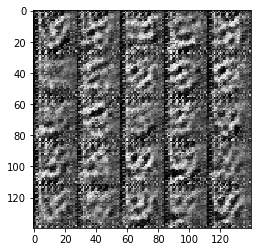

Epoch 1/2... Batch Count 1100... Discriminator Loss: 0.4347... Generator Loss: 3.2941
Epoch 1/2... Batch Count 1110... Discriminator Loss: 0.4593... Generator Loss: 3.0232
Epoch 1/2... Batch Count 1120... Discriminator Loss: 0.6488... Generator Loss: 1.9605
Epoch 1/2... Batch Count 1130... Discriminator Loss: 0.7083... Generator Loss: 2.2735
Epoch 1/2... Batch Count 1140... Discriminator Loss: 0.4144... Generator Loss: 9.0163
Epoch 1/2... Batch Count 1150... Discriminator Loss: 0.5240... Generator Loss: 4.6065
Epoch 1/2... Batch Count 1160... Discriminator Loss: 0.5621... Generator Loss: 4.2175
Epoch 1/2... Batch Count 1170... Discriminator Loss: 0.4734... Generator Loss: 4.4051
Epoch 1/2... Batch Count 1180... Discriminator Loss: 0.3825... Generator Loss: 5.2755
Epoch 1/2... Batch Count 1190... Discriminator Loss: 0.4101... Generator Loss: 3.7483


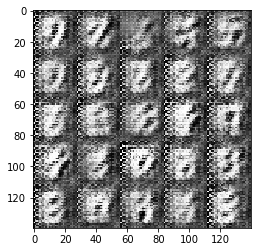

Epoch 1/2... Batch Count 1200... Discriminator Loss: 0.3605... Generator Loss: 4.3440
Epoch 1/2... Batch Count 1210... Discriminator Loss: 0.4034... Generator Loss: 3.4727
Epoch 1/2... Batch Count 1220... Discriminator Loss: 0.4291... Generator Loss: 3.0345
Epoch 1/2... Batch Count 1230... Discriminator Loss: 0.4290... Generator Loss: 5.5533
Epoch 1/2... Batch Count 1240... Discriminator Loss: 0.5021... Generator Loss: 4.0028
Epoch 1/2... Batch Count 1250... Discriminator Loss: 1.0251... Generator Loss: 1.1888
Epoch 1/2... Batch Count 1260... Discriminator Loss: 0.8329... Generator Loss: 1.8213
Epoch 1/2... Batch Count 1270... Discriminator Loss: 0.8257... Generator Loss: 2.1417
Epoch 1/2... Batch Count 1280... Discriminator Loss: 0.5084... Generator Loss: 3.7817
Epoch 1/2... Batch Count 1290... Discriminator Loss: 0.5161... Generator Loss: 3.1865


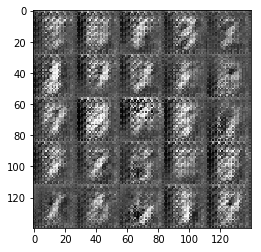

Epoch 1/2... Batch Count 1300... Discriminator Loss: 0.5887... Generator Loss: 2.2843
Epoch 1/2... Batch Count 1310... Discriminator Loss: 0.4526... Generator Loss: 4.8980
Epoch 1/2... Batch Count 1320... Discriminator Loss: 0.4085... Generator Loss: 3.8444
Epoch 1/2... Batch Count 1330... Discriminator Loss: 0.5820... Generator Loss: 3.2618
Epoch 1/2... Batch Count 1340... Discriminator Loss: 0.6426... Generator Loss: 2.4312
Epoch 1/2... Batch Count 1350... Discriminator Loss: 0.8340... Generator Loss: 1.8396
Epoch 1/2... Batch Count 1360... Discriminator Loss: 0.5916... Generator Loss: 2.2986
Epoch 1/2... Batch Count 1370... Discriminator Loss: 0.4099... Generator Loss: 3.8826
Epoch 1/2... Batch Count 1380... Discriminator Loss: 0.4004... Generator Loss: 4.5937
Epoch 1/2... Batch Count 1390... Discriminator Loss: 0.4703... Generator Loss: 3.4780


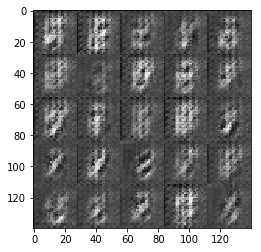

Epoch 1/2... Batch Count 1400... Discriminator Loss: 0.6054... Generator Loss: 2.5215
Epoch 1/2... Batch Count 1410... Discriminator Loss: 0.4946... Generator Loss: 2.7581
Epoch 1/2... Batch Count 1420... Discriminator Loss: 0.4352... Generator Loss: 3.9216
Epoch 1/2... Batch Count 1430... Discriminator Loss: 0.8020... Generator Loss: 1.6896
Epoch 1/2... Batch Count 1440... Discriminator Loss: 0.6701... Generator Loss: 3.8172
Epoch 1/2... Batch Count 1450... Discriminator Loss: 0.4666... Generator Loss: 3.4554
Epoch 1/2... Batch Count 1460... Discriminator Loss: 0.5434... Generator Loss: 2.2210
Epoch 1/2... Batch Count 1470... Discriminator Loss: 0.4575... Generator Loss: 3.3309
Epoch 1/2... Batch Count 1480... Discriminator Loss: 0.3942... Generator Loss: 3.4200
Epoch 1/2... Batch Count 1490... Discriminator Loss: 0.4496... Generator Loss: 2.6119


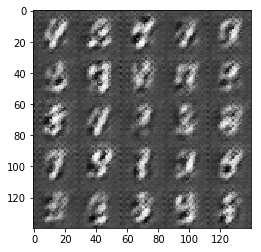

Epoch 1/2... Batch Count 1500... Discriminator Loss: 0.4521... Generator Loss: 2.5712
Epoch 1/2... Batch Count 1510... Discriminator Loss: 0.4879... Generator Loss: 2.6625
Epoch 1/2... Batch Count 1520... Discriminator Loss: 0.5339... Generator Loss: 2.4678
Epoch 1/2... Batch Count 1530... Discriminator Loss: 0.4255... Generator Loss: 3.7970
Epoch 1/2... Batch Count 1540... Discriminator Loss: 0.4393... Generator Loss: 2.9215
Epoch 1/2... Batch Count 1550... Discriminator Loss: 0.4266... Generator Loss: 4.1289
Epoch 1/2... Batch Count 1560... Discriminator Loss: 0.6612... Generator Loss: 1.8280
Epoch 1/2... Batch Count 1570... Discriminator Loss: 0.5120... Generator Loss: 2.5628
Epoch 1/2... Batch Count 1580... Discriminator Loss: 0.4525... Generator Loss: 2.9518
Epoch 1/2... Batch Count 1590... Discriminator Loss: 0.3879... Generator Loss: 3.5840


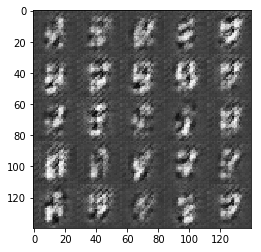

Epoch 1/2... Batch Count 1600... Discriminator Loss: 0.4235... Generator Loss: 3.3217
Epoch 1/2... Batch Count 1610... Discriminator Loss: 0.4312... Generator Loss: 2.9359
Epoch 1/2... Batch Count 1620... Discriminator Loss: 0.4061... Generator Loss: 3.6078
Epoch 1/2... Batch Count 1630... Discriminator Loss: 0.3743... Generator Loss: 4.4603
Epoch 1/2... Batch Count 1640... Discriminator Loss: 0.4222... Generator Loss: 4.7351
Epoch 1/2... Batch Count 1650... Discriminator Loss: 0.4071... Generator Loss: 3.2397
Epoch 1/2... Batch Count 1660... Discriminator Loss: 0.4246... Generator Loss: 3.0410
Epoch 1/2... Batch Count 1670... Discriminator Loss: 0.4824... Generator Loss: 4.0922
Epoch 1/2... Batch Count 1680... Discriminator Loss: 0.7999... Generator Loss: 1.4045
Epoch 1/2... Batch Count 1690... Discriminator Loss: 0.5029... Generator Loss: 2.3362


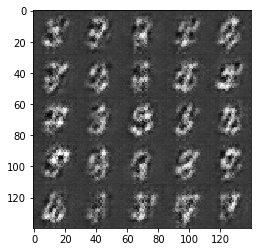

Epoch 1/2... Batch Count 1700... Discriminator Loss: 0.4429... Generator Loss: 2.9253
Epoch 1/2... Batch Count 1710... Discriminator Loss: 0.4265... Generator Loss: 3.0338
Epoch 1/2... Batch Count 1720... Discriminator Loss: 0.4496... Generator Loss: 3.4282
Epoch 1/2... Batch Count 1730... Discriminator Loss: 0.4080... Generator Loss: 3.1409
Epoch 1/2... Batch Count 1740... Discriminator Loss: 0.4393... Generator Loss: 4.0980
Epoch 1/2... Batch Count 1750... Discriminator Loss: 0.4290... Generator Loss: 3.6360
Epoch 1/2... Batch Count 1760... Discriminator Loss: 0.3972... Generator Loss: 4.3589
Epoch 1/2... Batch Count 1770... Discriminator Loss: 0.4945... Generator Loss: 3.2039
Epoch 1/2... Batch Count 1780... Discriminator Loss: 0.4469... Generator Loss: 2.7038
Epoch 1/2... Batch Count 1790... Discriminator Loss: 0.3810... Generator Loss: 4.2944


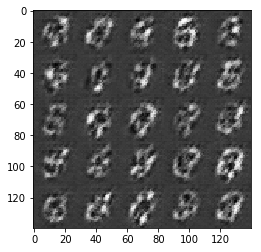

Epoch 1/2... Batch Count 1800... Discriminator Loss: 0.4013... Generator Loss: 3.7842
Epoch 1/2... Batch Count 1810... Discriminator Loss: 0.3890... Generator Loss: 3.5628
Epoch 1/2... Batch Count 1820... Discriminator Loss: 0.3986... Generator Loss: 3.8038
Epoch 1/2... Batch Count 1830... Discriminator Loss: 0.4675... Generator Loss: 4.1988
Epoch 1/2... Batch Count 1840... Discriminator Loss: 0.3887... Generator Loss: 3.8558
Epoch 1/2... Batch Count 1850... Discriminator Loss: 0.4134... Generator Loss: 3.7744
Epoch 1/2... Batch Count 1860... Discriminator Loss: 0.3747... Generator Loss: 4.0208
Epoch 1/2... Batch Count 1870... Discriminator Loss: 0.3872... Generator Loss: 3.4233
Epoch 2/2... Batch Count 1880... Discriminator Loss: 0.4101... Generator Loss: 3.2877
Epoch 2/2... Batch Count 1890... Discriminator Loss: 0.4314... Generator Loss: 5.3612


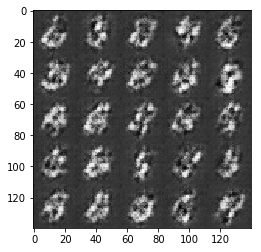

Epoch 2/2... Batch Count 1900... Discriminator Loss: 0.3959... Generator Loss: 3.1204
Epoch 2/2... Batch Count 1910... Discriminator Loss: 0.4412... Generator Loss: 3.3068
Epoch 2/2... Batch Count 1920... Discriminator Loss: 0.4288... Generator Loss: 2.9913
Epoch 2/2... Batch Count 1930... Discriminator Loss: 0.3867... Generator Loss: 3.7089
Epoch 2/2... Batch Count 1940... Discriminator Loss: 0.4146... Generator Loss: 4.7756
Epoch 2/2... Batch Count 1950... Discriminator Loss: 0.3516... Generator Loss: 4.8180
Epoch 2/2... Batch Count 1960... Discriminator Loss: 0.4089... Generator Loss: 4.6360
Epoch 2/2... Batch Count 1970... Discriminator Loss: 0.3733... Generator Loss: 4.2965
Epoch 2/2... Batch Count 1980... Discriminator Loss: 0.3977... Generator Loss: 3.4323
Epoch 2/2... Batch Count 1990... Discriminator Loss: 0.3719... Generator Loss: 3.8850


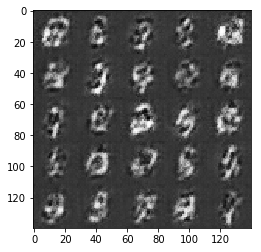

Epoch 2/2... Batch Count 2000... Discriminator Loss: 0.3666... Generator Loss: 4.9704
Epoch 2/2... Batch Count 2010... Discriminator Loss: 0.4230... Generator Loss: 4.6213
Epoch 2/2... Batch Count 2020... Discriminator Loss: 0.4202... Generator Loss: 5.0533
Epoch 2/2... Batch Count 2030... Discriminator Loss: 0.3845... Generator Loss: 4.9501
Epoch 2/2... Batch Count 2040... Discriminator Loss: 0.3922... Generator Loss: 5.1039
Epoch 2/2... Batch Count 2050... Discriminator Loss: 0.3947... Generator Loss: 4.2568
Epoch 2/2... Batch Count 2060... Discriminator Loss: 0.3831... Generator Loss: 4.5454
Epoch 2/2... Batch Count 2070... Discriminator Loss: 0.3777... Generator Loss: 5.7296
Epoch 2/2... Batch Count 2080... Discriminator Loss: 0.4128... Generator Loss: 4.0509
Epoch 2/2... Batch Count 2090... Discriminator Loss: 0.3869... Generator Loss: 3.7387


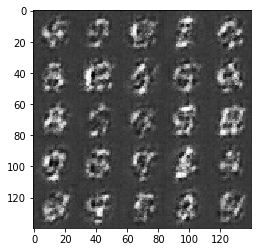

Epoch 2/2... Batch Count 2100... Discriminator Loss: 0.3749... Generator Loss: 4.0045
Epoch 2/2... Batch Count 2110... Discriminator Loss: 0.3916... Generator Loss: 3.6473
Epoch 2/2... Batch Count 2120... Discriminator Loss: 0.3539... Generator Loss: 4.3343
Epoch 2/2... Batch Count 2130... Discriminator Loss: 0.3689... Generator Loss: 4.0504
Epoch 2/2... Batch Count 2140... Discriminator Loss: 0.3941... Generator Loss: 3.2683
Epoch 2/2... Batch Count 2150... Discriminator Loss: 0.3834... Generator Loss: 3.8043
Epoch 2/2... Batch Count 2160... Discriminator Loss: 0.3663... Generator Loss: 3.7550
Epoch 2/2... Batch Count 2170... Discriminator Loss: 0.3605... Generator Loss: 4.2080
Epoch 2/2... Batch Count 2180... Discriminator Loss: 0.3724... Generator Loss: 3.8559
Epoch 2/2... Batch Count 2190... Discriminator Loss: 0.3689... Generator Loss: 4.0154


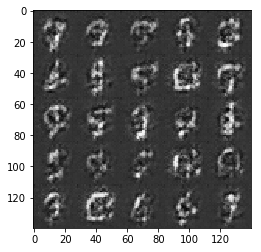

Epoch 2/2... Batch Count 2200... Discriminator Loss: 0.3575... Generator Loss: 4.1874
Epoch 2/2... Batch Count 2210... Discriminator Loss: 0.3504... Generator Loss: 4.2818
Epoch 2/2... Batch Count 2220... Discriminator Loss: 0.3890... Generator Loss: 3.7919
Epoch 2/2... Batch Count 2230... Discriminator Loss: 0.3886... Generator Loss: 3.3049
Epoch 2/2... Batch Count 2240... Discriminator Loss: 0.3587... Generator Loss: 4.5972
Epoch 2/2... Batch Count 2250... Discriminator Loss: 0.3843... Generator Loss: 3.3049
Epoch 2/2... Batch Count 2260... Discriminator Loss: 0.3565... Generator Loss: 4.3298
Epoch 2/2... Batch Count 2270... Discriminator Loss: 0.4023... Generator Loss: 3.1985
Epoch 2/2... Batch Count 2280... Discriminator Loss: 0.4186... Generator Loss: 3.0423
Epoch 2/2... Batch Count 2290... Discriminator Loss: 0.3840... Generator Loss: 3.6060


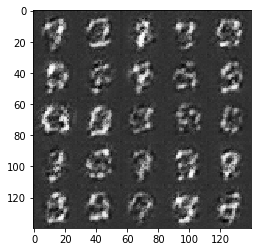

Epoch 2/2... Batch Count 2300... Discriminator Loss: 0.3574... Generator Loss: 5.2074
Epoch 2/2... Batch Count 2310... Discriminator Loss: 0.4048... Generator Loss: 4.4216
Epoch 2/2... Batch Count 2320... Discriminator Loss: 0.3630... Generator Loss: 4.1590
Epoch 2/2... Batch Count 2330... Discriminator Loss: 0.3881... Generator Loss: 3.4885
Epoch 2/2... Batch Count 2340... Discriminator Loss: 0.3588... Generator Loss: 4.1753
Epoch 2/2... Batch Count 2350... Discriminator Loss: 0.3960... Generator Loss: 3.3063
Epoch 2/2... Batch Count 2360... Discriminator Loss: 0.3733... Generator Loss: 5.4454
Epoch 2/2... Batch Count 2370... Discriminator Loss: 0.3680... Generator Loss: 5.2178
Epoch 2/2... Batch Count 2380... Discriminator Loss: 0.3696... Generator Loss: 4.1356
Epoch 2/2... Batch Count 2390... Discriminator Loss: 0.3794... Generator Loss: 3.5039


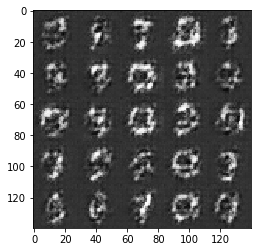

Epoch 2/2... Batch Count 2400... Discriminator Loss: 0.3908... Generator Loss: 4.2916
Epoch 2/2... Batch Count 2410... Discriminator Loss: 0.3571... Generator Loss: 4.6598
Epoch 2/2... Batch Count 2420... Discriminator Loss: 0.3678... Generator Loss: 3.9288
Epoch 2/2... Batch Count 2430... Discriminator Loss: 0.3813... Generator Loss: 3.3838
Epoch 2/2... Batch Count 2440... Discriminator Loss: 0.3578... Generator Loss: 4.3350
Epoch 2/2... Batch Count 2450... Discriminator Loss: 0.3679... Generator Loss: 4.1779
Epoch 2/2... Batch Count 2460... Discriminator Loss: 0.3715... Generator Loss: 3.7623
Epoch 2/2... Batch Count 2470... Discriminator Loss: 0.3621... Generator Loss: 3.9722
Epoch 2/2... Batch Count 2480... Discriminator Loss: 0.3712... Generator Loss: 3.9132
Epoch 2/2... Batch Count 2490... Discriminator Loss: 0.3741... Generator Loss: 3.6052


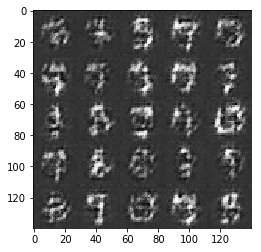

Epoch 2/2... Batch Count 2500... Discriminator Loss: 0.3523... Generator Loss: 4.6266
Epoch 2/2... Batch Count 2510... Discriminator Loss: 0.4036... Generator Loss: 3.0638
Epoch 2/2... Batch Count 2520... Discriminator Loss: 0.3556... Generator Loss: 4.2974
Epoch 2/2... Batch Count 2530... Discriminator Loss: 0.3804... Generator Loss: 5.5238
Epoch 2/2... Batch Count 2540... Discriminator Loss: 0.4061... Generator Loss: 3.1014
Epoch 2/2... Batch Count 2550... Discriminator Loss: 0.3788... Generator Loss: 4.5693
Epoch 2/2... Batch Count 2560... Discriminator Loss: 0.3622... Generator Loss: 4.2198
Epoch 2/2... Batch Count 2570... Discriminator Loss: 0.3738... Generator Loss: 4.7423
Epoch 2/2... Batch Count 2580... Discriminator Loss: 0.3532... Generator Loss: 4.8522
Epoch 2/2... Batch Count 2590... Discriminator Loss: 0.3571... Generator Loss: 4.2043


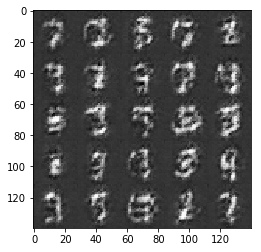

Epoch 2/2... Batch Count 2600... Discriminator Loss: 0.3730... Generator Loss: 5.3949
Epoch 2/2... Batch Count 2610... Discriminator Loss: 0.3655... Generator Loss: 3.9927
Epoch 2/2... Batch Count 2620... Discriminator Loss: 0.3730... Generator Loss: 4.0916
Epoch 2/2... Batch Count 2630... Discriminator Loss: 0.3632... Generator Loss: 3.9935
Epoch 2/2... Batch Count 2640... Discriminator Loss: 0.5151... Generator Loss: 2.3077
Epoch 2/2... Batch Count 2650... Discriminator Loss: 0.3724... Generator Loss: 4.3872
Epoch 2/2... Batch Count 2660... Discriminator Loss: 0.3548... Generator Loss: 4.9690
Epoch 2/2... Batch Count 2670... Discriminator Loss: 0.3624... Generator Loss: 4.7947
Epoch 2/2... Batch Count 2680... Discriminator Loss: 0.3534... Generator Loss: 4.5927
Epoch 2/2... Batch Count 2690... Discriminator Loss: 0.3478... Generator Loss: 4.7865


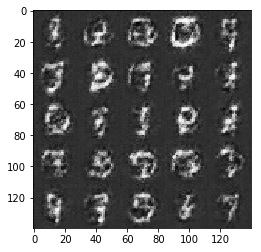

Epoch 2/2... Batch Count 2700... Discriminator Loss: 0.3490... Generator Loss: 5.1933
Epoch 2/2... Batch Count 2710... Discriminator Loss: 0.3629... Generator Loss: 4.2576
Epoch 2/2... Batch Count 2720... Discriminator Loss: 0.3483... Generator Loss: 4.8510
Epoch 2/2... Batch Count 2730... Discriminator Loss: 0.3642... Generator Loss: 4.0941
Epoch 2/2... Batch Count 2740... Discriminator Loss: 0.3608... Generator Loss: 4.3617
Epoch 2/2... Batch Count 2750... Discriminator Loss: 0.3535... Generator Loss: 4.6539
Epoch 2/2... Batch Count 2760... Discriminator Loss: 0.3510... Generator Loss: 4.6594
Epoch 2/2... Batch Count 2770... Discriminator Loss: 0.3548... Generator Loss: 4.6740
Epoch 2/2... Batch Count 2780... Discriminator Loss: 0.3669... Generator Loss: 4.0077
Epoch 2/2... Batch Count 2790... Discriminator Loss: 0.3791... Generator Loss: 4.0819


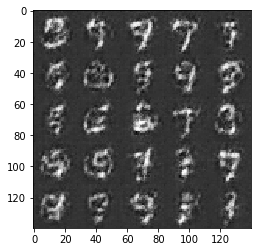

Epoch 2/2... Batch Count 2800... Discriminator Loss: 0.3516... Generator Loss: 5.2022
Epoch 2/2... Batch Count 2810... Discriminator Loss: 0.3976... Generator Loss: 3.6069
Epoch 2/2... Batch Count 2820... Discriminator Loss: 0.4314... Generator Loss: 3.4819
Epoch 2/2... Batch Count 2830... Discriminator Loss: 0.3880... Generator Loss: 3.3988
Epoch 2/2... Batch Count 2840... Discriminator Loss: 0.3505... Generator Loss: 4.6163
Epoch 2/2... Batch Count 2850... Discriminator Loss: 0.3440... Generator Loss: 4.5398
Epoch 2/2... Batch Count 2860... Discriminator Loss: 0.3606... Generator Loss: 4.1187
Epoch 2/2... Batch Count 2870... Discriminator Loss: 0.3582... Generator Loss: 4.0230
Epoch 2/2... Batch Count 2880... Discriminator Loss: 0.3546... Generator Loss: 3.9761
Epoch 2/2... Batch Count 2890... Discriminator Loss: 0.4278... Generator Loss: 3.7939


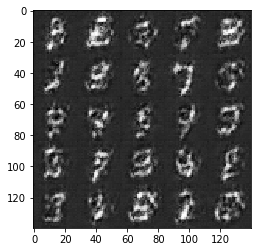

Epoch 2/2... Batch Count 2900... Discriminator Loss: 0.3604... Generator Loss: 4.1046
Epoch 2/2... Batch Count 2910... Discriminator Loss: 0.4009... Generator Loss: 3.0557
Epoch 2/2... Batch Count 2920... Discriminator Loss: 0.3521... Generator Loss: 4.3428
Epoch 2/2... Batch Count 2930... Discriminator Loss: 0.3583... Generator Loss: 3.9502
Epoch 2/2... Batch Count 2940... Discriminator Loss: 0.3439... Generator Loss: 5.0923
Epoch 2/2... Batch Count 2950... Discriminator Loss: 0.3655... Generator Loss: 3.7496
Epoch 2/2... Batch Count 2960... Discriminator Loss: 0.3706... Generator Loss: 3.6793
Epoch 2/2... Batch Count 2970... Discriminator Loss: 0.3524... Generator Loss: 4.4758
Epoch 2/2... Batch Count 2980... Discriminator Loss: 0.3692... Generator Loss: 3.8565
Epoch 2/2... Batch Count 2990... Discriminator Loss: 0.3581... Generator Loss: 4.4431


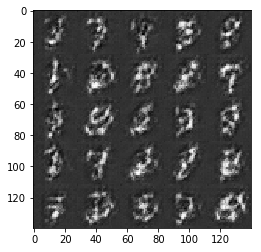

Epoch 2/2... Batch Count 3000... Discriminator Loss: 0.3597... Generator Loss: 4.0991
Epoch 2/2... Batch Count 3010... Discriminator Loss: 0.3832... Generator Loss: 5.3494
Epoch 2/2... Batch Count 3020... Discriminator Loss: 0.3979... Generator Loss: 3.6125
Epoch 2/2... Batch Count 3030... Discriminator Loss: 0.4219... Generator Loss: 4.9855
Epoch 2/2... Batch Count 3040... Discriminator Loss: 0.3716... Generator Loss: 5.5508
Epoch 2/2... Batch Count 3050... Discriminator Loss: 0.3862... Generator Loss: 3.1871
Epoch 2/2... Batch Count 3060... Discriminator Loss: 0.3466... Generator Loss: 5.1720
Epoch 2/2... Batch Count 3070... Discriminator Loss: 0.3618... Generator Loss: 4.5705
Epoch 2/2... Batch Count 3080... Discriminator Loss: 0.3592... Generator Loss: 4.2680
Epoch 2/2... Batch Count 3090... Discriminator Loss: 0.3643... Generator Loss: 3.8925


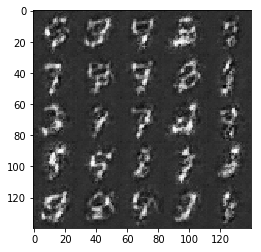

Epoch 2/2... Batch Count 3100... Discriminator Loss: 0.3604... Generator Loss: 5.8224
Epoch 2/2... Batch Count 3110... Discriminator Loss: 0.3679... Generator Loss: 4.2243
Epoch 2/2... Batch Count 3120... Discriminator Loss: 0.3721... Generator Loss: 3.5955
Epoch 2/2... Batch Count 3130... Discriminator Loss: 0.3903... Generator Loss: 3.3915
Epoch 2/2... Batch Count 3140... Discriminator Loss: 0.3755... Generator Loss: 5.2097
Epoch 2/2... Batch Count 3150... Discriminator Loss: 0.3966... Generator Loss: 3.9800
Epoch 2/2... Batch Count 3160... Discriminator Loss: 0.3771... Generator Loss: 3.9613
Epoch 2/2... Batch Count 3170... Discriminator Loss: 0.4073... Generator Loss: 2.8480
Epoch 2/2... Batch Count 3180... Discriminator Loss: 0.3520... Generator Loss: 4.5534
Epoch 2/2... Batch Count 3190... Discriminator Loss: 0.3422... Generator Loss: 4.8906


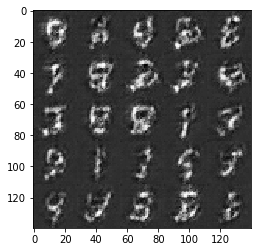

Epoch 2/2... Batch Count 3200... Discriminator Loss: 0.3686... Generator Loss: 4.1586
Epoch 2/2... Batch Count 3210... Discriminator Loss: 0.3512... Generator Loss: 4.9360
Epoch 2/2... Batch Count 3220... Discriminator Loss: 0.3624... Generator Loss: 4.2326
Epoch 2/2... Batch Count 3230... Discriminator Loss: 0.3782... Generator Loss: 3.3781
Epoch 2/2... Batch Count 3240... Discriminator Loss: 0.3961... Generator Loss: 3.5559
Epoch 2/2... Batch Count 3250... Discriminator Loss: 0.3475... Generator Loss: 4.8995
Epoch 2/2... Batch Count 3260... Discriminator Loss: 0.3400... Generator Loss: 5.2117
Epoch 2/2... Batch Count 3270... Discriminator Loss: 0.3477... Generator Loss: 4.8365
Epoch 2/2... Batch Count 3280... Discriminator Loss: 0.3804... Generator Loss: 3.5462
Epoch 2/2... Batch Count 3290... Discriminator Loss: 0.3539... Generator Loss: 4.0655


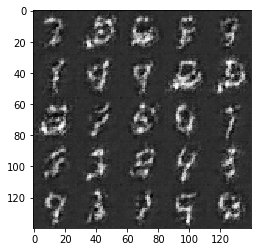

Epoch 2/2... Batch Count 3300... Discriminator Loss: 0.3459... Generator Loss: 4.7492
Epoch 2/2... Batch Count 3310... Discriminator Loss: 0.3448... Generator Loss: 4.7429
Epoch 2/2... Batch Count 3320... Discriminator Loss: 0.3413... Generator Loss: 4.8975
Epoch 2/2... Batch Count 3330... Discriminator Loss: 0.4459... Generator Loss: 5.1839
Epoch 2/2... Batch Count 3340... Discriminator Loss: 0.3618... Generator Loss: 5.2605
Epoch 2/2... Batch Count 3350... Discriminator Loss: 0.4363... Generator Loss: 6.1879
Epoch 2/2... Batch Count 3360... Discriminator Loss: 0.3663... Generator Loss: 4.4462
Epoch 2/2... Batch Count 3370... Discriminator Loss: 0.4080... Generator Loss: 3.3320
Epoch 2/2... Batch Count 3380... Discriminator Loss: 0.3559... Generator Loss: 4.7222
Epoch 2/2... Batch Count 3390... Discriminator Loss: 0.4252... Generator Loss: 4.1412


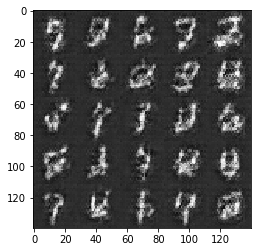

Epoch 2/2... Batch Count 3400... Discriminator Loss: 0.3493... Generator Loss: 4.7640
Epoch 2/2... Batch Count 3410... Discriminator Loss: 0.3736... Generator Loss: 3.6203
Epoch 2/2... Batch Count 3420... Discriminator Loss: 0.3471... Generator Loss: 5.8711
Epoch 2/2... Batch Count 3430... Discriminator Loss: 0.3498... Generator Loss: 4.6583
Epoch 2/2... Batch Count 3440... Discriminator Loss: 0.3395... Generator Loss: 5.1483
Epoch 2/2... Batch Count 3450... Discriminator Loss: 0.3548... Generator Loss: 5.0324
Epoch 2/2... Batch Count 3460... Discriminator Loss: 0.3452... Generator Loss: 4.5296
Epoch 2/2... Batch Count 3470... Discriminator Loss: 0.3582... Generator Loss: 4.4274
Epoch 2/2... Batch Count 3480... Discriminator Loss: 0.3462... Generator Loss: 4.6504
Epoch 2/2... Batch Count 3490... Discriminator Loss: 0.3451... Generator Loss: 4.7939


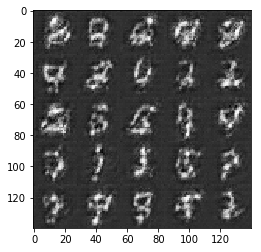

Epoch 2/2... Batch Count 3500... Discriminator Loss: 0.4099... Generator Loss: 2.8475
Epoch 2/2... Batch Count 3510... Discriminator Loss: 0.3724... Generator Loss: 3.5051
Epoch 2/2... Batch Count 3520... Discriminator Loss: 0.3554... Generator Loss: 4.1291
Epoch 2/2... Batch Count 3530... Discriminator Loss: 0.3675... Generator Loss: 4.4155
Epoch 2/2... Batch Count 3540... Discriminator Loss: 0.3568... Generator Loss: 4.1899
Epoch 2/2... Batch Count 3550... Discriminator Loss: 0.3543... Generator Loss: 4.8565
Epoch 2/2... Batch Count 3560... Discriminator Loss: 0.4670... Generator Loss: 5.2465
Epoch 2/2... Batch Count 3570... Discriminator Loss: 0.5664... Generator Loss: 4.8324
Epoch 2/2... Batch Count 3580... Discriminator Loss: 0.3533... Generator Loss: 4.5600
Epoch 2/2... Batch Count 3590... Discriminator Loss: 0.3849... Generator Loss: 3.8744


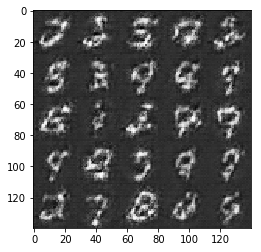

Epoch 2/2... Batch Count 3600... Discriminator Loss: 0.3645... Generator Loss: 3.7670
Epoch 2/2... Batch Count 3610... Discriminator Loss: 0.3891... Generator Loss: 3.8108
Epoch 2/2... Batch Count 3620... Discriminator Loss: 0.3532... Generator Loss: 4.5645
Epoch 2/2... Batch Count 3630... Discriminator Loss: 0.3841... Generator Loss: 3.7552
Epoch 2/2... Batch Count 3640... Discriminator Loss: 0.4134... Generator Loss: 2.9372
Epoch 2/2... Batch Count 3650... Discriminator Loss: 0.3569... Generator Loss: 4.6172
Epoch 2/2... Batch Count 3660... Discriminator Loss: 0.3599... Generator Loss: 4.2036
Epoch 2/2... Batch Count 3670... Discriminator Loss: 0.3555... Generator Loss: 4.2095
Epoch 2/2... Batch Count 3680... Discriminator Loss: 0.3627... Generator Loss: 4.8278
Epoch 2/2... Batch Count 3690... Discriminator Loss: 0.3536... Generator Loss: 4.0360


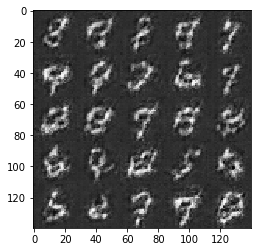

Epoch 2/2... Batch Count 3700... Discriminator Loss: 0.3873... Generator Loss: 3.4607
Epoch 2/2... Batch Count 3710... Discriminator Loss: 0.3668... Generator Loss: 3.9080
Epoch 2/2... Batch Count 3720... Discriminator Loss: 0.3520... Generator Loss: 4.2247
Epoch 2/2... Batch Count 3730... Discriminator Loss: 0.3516... Generator Loss: 4.2249
Epoch 2/2... Batch Count 3740... Discriminator Loss: 0.3634... Generator Loss: 4.4636
Epoch 2/2... Batch Count 3750... Discriminator Loss: 0.3900... Generator Loss: 4.3126


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.9
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch Count 10... Discriminator Loss: 2.6499... Generator Loss: 0.2798
Epoch 1/1... Batch Count 20... Discriminator Loss: 0.8808... Generator Loss: 2.0082
Epoch 1/1... Batch Count 30... Discriminator Loss: 0.6666... Generator Loss: 2.6786
Epoch 1/1... Batch Count 40... Discriminator Loss: 0.7541... Generator Loss: 1.5077
Epoch 1/1... Batch Count 50... Discriminator Loss: 0.5807... Generator Loss: 2.6103
Epoch 1/1... Batch Count 60... Discriminator Loss: 0.4771... Generator Loss: 3.1631
Epoch 1/1... Batch Count 70... Discriminator Loss: 0.4009... Generator Loss: 4.2062
Epoch 1/1... Batch Count 80... Discriminator Loss: 0.4500... Generator Loss: 3.1057
Epoch 1/1... Batch Count 90... Discriminator Loss: 0.4044... Generator Loss: 4.6828


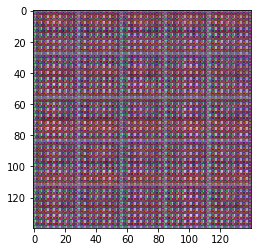

Epoch 1/1... Batch Count 100... Discriminator Loss: 0.3588... Generator Loss: 4.1828
Epoch 1/1... Batch Count 110... Discriminator Loss: 0.4218... Generator Loss: 4.0237
Epoch 1/1... Batch Count 120... Discriminator Loss: 0.4801... Generator Loss: 2.9833
Epoch 1/1... Batch Count 130... Discriminator Loss: 0.4348... Generator Loss: 2.9493
Epoch 1/1... Batch Count 140... Discriminator Loss: 0.4328... Generator Loss: 2.9890
Epoch 1/1... Batch Count 150... Discriminator Loss: 0.4138... Generator Loss: 3.3857
Epoch 1/1... Batch Count 160... Discriminator Loss: 0.4346... Generator Loss: 3.3665
Epoch 1/1... Batch Count 170... Discriminator Loss: 0.3770... Generator Loss: 3.5442
Epoch 1/1... Batch Count 180... Discriminator Loss: 0.4672... Generator Loss: 3.0952
Epoch 1/1... Batch Count 190... Discriminator Loss: 0.3915... Generator Loss: 4.3275


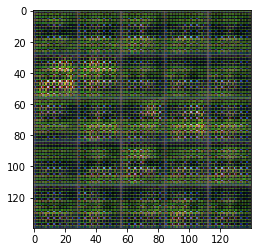

Epoch 1/1... Batch Count 200... Discriminator Loss: 0.3836... Generator Loss: 4.0477
Epoch 1/1... Batch Count 210... Discriminator Loss: 0.3755... Generator Loss: 4.1714
Epoch 1/1... Batch Count 220... Discriminator Loss: 0.4400... Generator Loss: 2.8043
Epoch 1/1... Batch Count 230... Discriminator Loss: 0.3785... Generator Loss: 3.6640
Epoch 1/1... Batch Count 240... Discriminator Loss: 0.4622... Generator Loss: 3.4130
Epoch 1/1... Batch Count 250... Discriminator Loss: 0.3677... Generator Loss: 4.3633
Epoch 1/1... Batch Count 260... Discriminator Loss: 0.4063... Generator Loss: 3.2458
Epoch 1/1... Batch Count 270... Discriminator Loss: 0.4200... Generator Loss: 3.8560
Epoch 1/1... Batch Count 280... Discriminator Loss: 0.3637... Generator Loss: 4.3427
Epoch 1/1... Batch Count 290... Discriminator Loss: 0.3566... Generator Loss: 4.5515


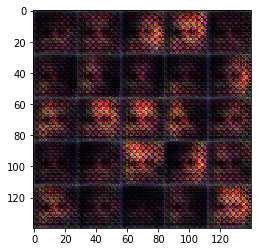

Epoch 1/1... Batch Count 300... Discriminator Loss: 0.3548... Generator Loss: 5.0586
Epoch 1/1... Batch Count 310... Discriminator Loss: 0.3561... Generator Loss: 4.2771
Epoch 1/1... Batch Count 320... Discriminator Loss: 0.3653... Generator Loss: 4.5502
Epoch 1/1... Batch Count 330... Discriminator Loss: 0.3512... Generator Loss: 4.7869
Epoch 1/1... Batch Count 340... Discriminator Loss: 0.3416... Generator Loss: 5.3978
Epoch 1/1... Batch Count 350... Discriminator Loss: 0.3603... Generator Loss: 4.8042
Epoch 1/1... Batch Count 360... Discriminator Loss: 0.3570... Generator Loss: 5.5972
Epoch 1/1... Batch Count 370... Discriminator Loss: 0.3884... Generator Loss: 3.3977
Epoch 1/1... Batch Count 380... Discriminator Loss: 0.3503... Generator Loss: 4.6909
Epoch 1/1... Batch Count 390... Discriminator Loss: 0.3578... Generator Loss: 4.1244


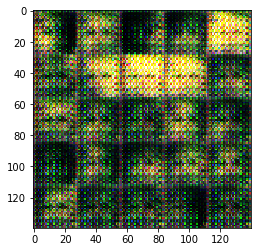

Epoch 1/1... Batch Count 400... Discriminator Loss: 0.3943... Generator Loss: 4.1571
Epoch 1/1... Batch Count 410... Discriminator Loss: 0.3673... Generator Loss: 4.9740
Epoch 1/1... Batch Count 420... Discriminator Loss: 0.3718... Generator Loss: 5.6256
Epoch 1/1... Batch Count 430... Discriminator Loss: 0.3487... Generator Loss: 5.2115
Epoch 1/1... Batch Count 440... Discriminator Loss: 0.3720... Generator Loss: 4.5135
Epoch 1/1... Batch Count 450... Discriminator Loss: 0.3397... Generator Loss: 5.2780
Epoch 1/1... Batch Count 460... Discriminator Loss: 0.3643... Generator Loss: 4.4800
Epoch 1/1... Batch Count 470... Discriminator Loss: 0.3416... Generator Loss: 5.8331
Epoch 1/1... Batch Count 480... Discriminator Loss: 0.3392... Generator Loss: 5.1978
Epoch 1/1... Batch Count 490... Discriminator Loss: 0.3634... Generator Loss: 4.0165


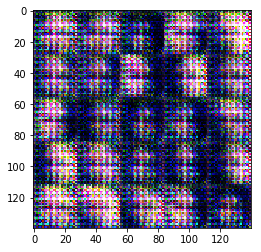

Epoch 1/1... Batch Count 500... Discriminator Loss: 0.3439... Generator Loss: 6.0040
Epoch 1/1... Batch Count 510... Discriminator Loss: 0.3532... Generator Loss: 3.9523
Epoch 1/1... Batch Count 520... Discriminator Loss: 0.3395... Generator Loss: 5.3793
Epoch 1/1... Batch Count 530... Discriminator Loss: 0.3532... Generator Loss: 4.7430
Epoch 1/1... Batch Count 540... Discriminator Loss: 0.3674... Generator Loss: 3.9234
Epoch 1/1... Batch Count 550... Discriminator Loss: 0.3822... Generator Loss: 5.9407
Epoch 1/1... Batch Count 560... Discriminator Loss: 0.3472... Generator Loss: 5.6578
Epoch 1/1... Batch Count 570... Discriminator Loss: 0.3503... Generator Loss: 4.3850
Epoch 1/1... Batch Count 580... Discriminator Loss: 0.3610... Generator Loss: 4.5055
Epoch 1/1... Batch Count 590... Discriminator Loss: 0.3540... Generator Loss: 4.0938


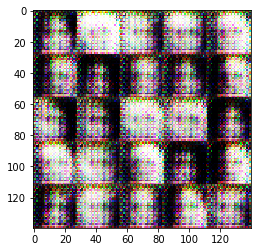

Epoch 1/1... Batch Count 600... Discriminator Loss: 0.3437... Generator Loss: 5.0256
Epoch 1/1... Batch Count 610... Discriminator Loss: 0.3424... Generator Loss: 5.2384
Epoch 1/1... Batch Count 620... Discriminator Loss: 0.3684... Generator Loss: 4.6891
Epoch 1/1... Batch Count 630... Discriminator Loss: 0.4285... Generator Loss: 2.5466
Epoch 1/1... Batch Count 640... Discriminator Loss: 0.3488... Generator Loss: 5.7551
Epoch 1/1... Batch Count 650... Discriminator Loss: 0.3467... Generator Loss: 5.3820
Epoch 1/1... Batch Count 660... Discriminator Loss: 0.4037... Generator Loss: 6.0443
Epoch 1/1... Batch Count 670... Discriminator Loss: 0.3470... Generator Loss: 4.6928
Epoch 1/1... Batch Count 680... Discriminator Loss: 0.3391... Generator Loss: 5.6718
Epoch 1/1... Batch Count 690... Discriminator Loss: 0.3993... Generator Loss: 3.5016


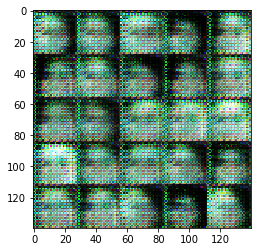

Epoch 1/1... Batch Count 700... Discriminator Loss: 0.3432... Generator Loss: 6.6535
Epoch 1/1... Batch Count 710... Discriminator Loss: 0.3722... Generator Loss: 4.3541
Epoch 1/1... Batch Count 720... Discriminator Loss: 0.3611... Generator Loss: 6.0863
Epoch 1/1... Batch Count 730... Discriminator Loss: 0.3988... Generator Loss: 3.8932
Epoch 1/1... Batch Count 740... Discriminator Loss: 0.3498... Generator Loss: 5.5473
Epoch 1/1... Batch Count 750... Discriminator Loss: 0.4059... Generator Loss: 3.3487
Epoch 1/1... Batch Count 760... Discriminator Loss: 0.5606... Generator Loss: 3.0349
Epoch 1/1... Batch Count 770... Discriminator Loss: 0.3404... Generator Loss: 7.2799
Epoch 1/1... Batch Count 780... Discriminator Loss: 0.3613... Generator Loss: 5.1623
Epoch 1/1... Batch Count 790... Discriminator Loss: 0.3917... Generator Loss: 3.4536


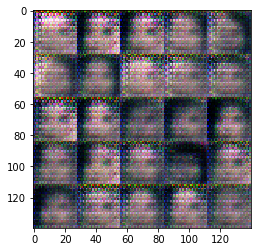

Epoch 1/1... Batch Count 800... Discriminator Loss: 0.6627... Generator Loss: 1.4285
Epoch 1/1... Batch Count 810... Discriminator Loss: 0.4194... Generator Loss: 3.4003
Epoch 1/1... Batch Count 820... Discriminator Loss: 0.4862... Generator Loss: 2.2110
Epoch 1/1... Batch Count 830... Discriminator Loss: 0.4080... Generator Loss: 3.1645
Epoch 1/1... Batch Count 840... Discriminator Loss: 0.6376... Generator Loss: 1.7648
Epoch 1/1... Batch Count 850... Discriminator Loss: 0.9395... Generator Loss: 3.8321
Epoch 1/1... Batch Count 860... Discriminator Loss: 0.3972... Generator Loss: 4.2535
Epoch 1/1... Batch Count 870... Discriminator Loss: 0.5279... Generator Loss: 2.7359
Epoch 1/1... Batch Count 880... Discriminator Loss: 0.5086... Generator Loss: 11.8339
Epoch 1/1... Batch Count 890... Discriminator Loss: 0.4443... Generator Loss: 8.5689


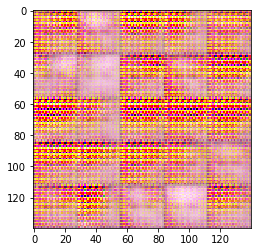

Epoch 1/1... Batch Count 900... Discriminator Loss: 0.3982... Generator Loss: 6.5816
Epoch 1/1... Batch Count 910... Discriminator Loss: 0.3739... Generator Loss: 4.7518
Epoch 1/1... Batch Count 920... Discriminator Loss: 0.3518... Generator Loss: 7.1466
Epoch 1/1... Batch Count 930... Discriminator Loss: 0.3443... Generator Loss: 6.5738
Epoch 1/1... Batch Count 940... Discriminator Loss: 0.3560... Generator Loss: 6.4451
Epoch 1/1... Batch Count 950... Discriminator Loss: 0.3526... Generator Loss: 6.0265
Epoch 1/1... Batch Count 960... Discriminator Loss: 0.3658... Generator Loss: 6.1643
Epoch 1/1... Batch Count 970... Discriminator Loss: 0.3439... Generator Loss: 5.0754
Epoch 1/1... Batch Count 980... Discriminator Loss: 0.3782... Generator Loss: 5.2507
Epoch 1/1... Batch Count 990... Discriminator Loss: 0.3868... Generator Loss: 3.5376


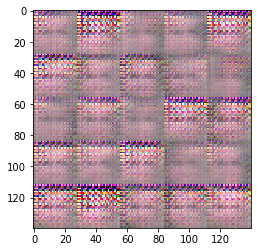

Epoch 1/1... Batch Count 1000... Discriminator Loss: 0.3476... Generator Loss: 4.6951
Epoch 1/1... Batch Count 1010... Discriminator Loss: 0.4041... Generator Loss: 3.3566
Epoch 1/1... Batch Count 1020... Discriminator Loss: 0.3590... Generator Loss: 4.3787
Epoch 1/1... Batch Count 1030... Discriminator Loss: 0.3528... Generator Loss: 4.6057
Epoch 1/1... Batch Count 1040... Discriminator Loss: 0.3731... Generator Loss: 3.9648
Epoch 1/1... Batch Count 1050... Discriminator Loss: 0.3986... Generator Loss: 3.0591
Epoch 1/1... Batch Count 1060... Discriminator Loss: 0.3739... Generator Loss: 3.9451
Epoch 1/1... Batch Count 1070... Discriminator Loss: 0.3500... Generator Loss: 4.9694
Epoch 1/1... Batch Count 1080... Discriminator Loss: 0.3838... Generator Loss: 3.3806
Epoch 1/1... Batch Count 1090... Discriminator Loss: 0.3539... Generator Loss: 4.4070


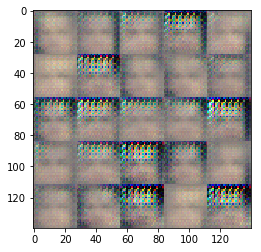

Epoch 1/1... Batch Count 1100... Discriminator Loss: 0.3517... Generator Loss: 4.3250
Epoch 1/1... Batch Count 1110... Discriminator Loss: 0.3591... Generator Loss: 4.2320
Epoch 1/1... Batch Count 1120... Discriminator Loss: 0.4057... Generator Loss: 3.0911
Epoch 1/1... Batch Count 1130... Discriminator Loss: 0.4053... Generator Loss: 6.0334
Epoch 1/1... Batch Count 1140... Discriminator Loss: 0.5225... Generator Loss: 2.4038
Epoch 1/1... Batch Count 1150... Discriminator Loss: 0.4651... Generator Loss: 2.7382
Epoch 1/1... Batch Count 1160... Discriminator Loss: 0.8188... Generator Loss: 1.2713
Epoch 1/1... Batch Count 1170... Discriminator Loss: 0.5599... Generator Loss: 7.4739
Epoch 1/1... Batch Count 1180... Discriminator Loss: 0.5414... Generator Loss: 4.3570
Epoch 1/1... Batch Count 1190... Discriminator Loss: 0.4722... Generator Loss: 2.9245


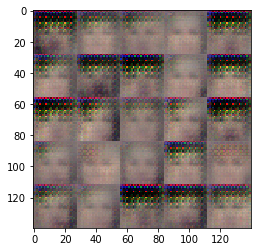

Epoch 1/1... Batch Count 1200... Discriminator Loss: 0.7432... Generator Loss: 2.0668
Epoch 1/1... Batch Count 1210... Discriminator Loss: 0.6366... Generator Loss: 3.0412
Epoch 1/1... Batch Count 1220... Discriminator Loss: 0.3781... Generator Loss: 7.8714
Epoch 1/1... Batch Count 1230... Discriminator Loss: 0.4596... Generator Loss: 3.0576
Epoch 1/1... Batch Count 1240... Discriminator Loss: 0.5298... Generator Loss: 1.9874
Epoch 1/1... Batch Count 1250... Discriminator Loss: 0.4743... Generator Loss: 3.5338
Epoch 1/1... Batch Count 1260... Discriminator Loss: 0.3773... Generator Loss: 3.6223
Epoch 1/1... Batch Count 1270... Discriminator Loss: 0.3561... Generator Loss: 5.0367
Epoch 1/1... Batch Count 1280... Discriminator Loss: 0.3523... Generator Loss: 5.4593
Epoch 1/1... Batch Count 1290... Discriminator Loss: 0.3952... Generator Loss: 3.7797


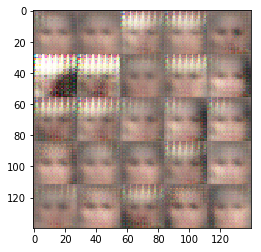

Epoch 1/1... Batch Count 1300... Discriminator Loss: 0.4371... Generator Loss: 2.6986
Epoch 1/1... Batch Count 1310... Discriminator Loss: 1.2254... Generator Loss: 1.1201
Epoch 1/1... Batch Count 1320... Discriminator Loss: 0.5212... Generator Loss: 4.6028
Epoch 1/1... Batch Count 1330... Discriminator Loss: 0.4249... Generator Loss: 5.0963
Epoch 1/1... Batch Count 1340... Discriminator Loss: 1.2392... Generator Loss: 0.9955
Epoch 1/1... Batch Count 1350... Discriminator Loss: 0.5836... Generator Loss: 5.8049
Epoch 1/1... Batch Count 1360... Discriminator Loss: 0.5036... Generator Loss: 7.7847
Epoch 1/1... Batch Count 1370... Discriminator Loss: 0.4580... Generator Loss: 3.4462
Epoch 1/1... Batch Count 1380... Discriminator Loss: 0.4128... Generator Loss: 3.0329
Epoch 1/1... Batch Count 1390... Discriminator Loss: 0.3672... Generator Loss: 5.6357


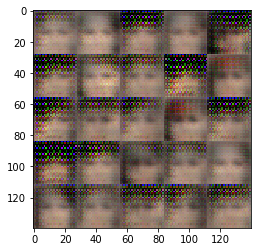

Epoch 1/1... Batch Count 1400... Discriminator Loss: 0.3972... Generator Loss: 3.6846
Epoch 1/1... Batch Count 1410... Discriminator Loss: 0.3838... Generator Loss: 4.4286
Epoch 1/1... Batch Count 1420... Discriminator Loss: 0.4614... Generator Loss: 2.9147
Epoch 1/1... Batch Count 1430... Discriminator Loss: 0.4166... Generator Loss: 3.9836
Epoch 1/1... Batch Count 1440... Discriminator Loss: 0.4630... Generator Loss: 4.3001
Epoch 1/1... Batch Count 1450... Discriminator Loss: 0.3431... Generator Loss: 6.6741
Epoch 1/1... Batch Count 1460... Discriminator Loss: 0.4282... Generator Loss: 5.6235
Epoch 1/1... Batch Count 1470... Discriminator Loss: 0.3514... Generator Loss: 4.8481
Epoch 1/1... Batch Count 1480... Discriminator Loss: 0.3677... Generator Loss: 4.1243
Epoch 1/1... Batch Count 1490... Discriminator Loss: 0.5615... Generator Loss: 1.7587


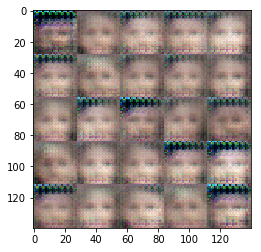

Epoch 1/1... Batch Count 1500... Discriminator Loss: 0.4637... Generator Loss: 2.6794
Epoch 1/1... Batch Count 1510... Discriminator Loss: 0.6536... Generator Loss: 1.9623
Epoch 1/1... Batch Count 1520... Discriminator Loss: 0.4023... Generator Loss: 5.8343
Epoch 1/1... Batch Count 1530... Discriminator Loss: 1.8140... Generator Loss: 0.8618
Epoch 1/1... Batch Count 1540... Discriminator Loss: 0.4830... Generator Loss: 4.7372
Epoch 1/1... Batch Count 1550... Discriminator Loss: 0.4999... Generator Loss: 2.7400
Epoch 1/1... Batch Count 1560... Discriminator Loss: 1.3495... Generator Loss: 0.8223
Epoch 1/1... Batch Count 1570... Discriminator Loss: 0.5954... Generator Loss: 2.3400


OSError: cannot identify image file './data\\img_align_celeba\\073183.jpg'

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.